# Noise injection into unmixing models ensemble

- Inject noise into the models for unmixing and verify its robustness against noise.
- Create N copies of the base model and augment them with noise.
Each model makes its own predictions, which are later aggregated to create
an ensemble final prediction.

- --data-file-path - path to the hyperspectral image (HSI).
- --ground-truth-path - path to the ground truth map containing
the fractions of abundances for entire HSI.
- --train-size - magnitude of the learning set that is utilized
to fine-tune the weights of the model.
- --sub-test-size - size of the test set to evaluate
the generalization of the model. It is sampled from the remaining
HSI excluding the training subset. If not specified, all non-training samples
constitute the test set.<br>Can be employed in the case of experiments
when changing the magnitudes of training sets while keeping the size of testing
sets constant.
- --val-size - fraction or size of the validation subset, it is designed to
monitor the overfitting.
- --channels-idx - index of the spectral dimension in input HSI.
- batch-size - number of samples per update step in the training phase.
- --shuffle - indicates whether to shuffle the dataset in experiment.
- --patience - stopping condition for a specific number of epochs without
improvement.
- --model-name - name of the utilized model, exemplary values:<br>
unmixing_pixel_based_cnn, unmixing_cube_based_cnn, unmixing_pixel_based_dcae,
unmixing_cube_based_dcae for the pixel-based, cube-based CNN and DCAE
respectively.
- --sample-size - number of spectral bands in a given HSI.
- --neighborhood-size - size of the spatial extent which is employed for each
sample in the form of local neighboring pixels. Most cases allows to leverage
the quality of the segmentation as well as the unmixing.
- --n-classes - number of endmembers in the HSI for which the abundances
will be estimated by the model.
- --lr - learning rate regulates the step size during weights updates in the training phase.
- --epochs - second stopping condition, i.e., the maximum number of epochs.
- --verbose - verbosity mode.
- --save-data - indicates whether to save the training and test data.

# Train base Pixel-based CNN
We specify the necessary parameters for the experiment.

In [1]:
# Execute pixel-based CNN:
from os.path import join

base_path = r'../datasets/urban'
data_file_path = join(base_path, 'urban.npy')
ground_truth_path = join(base_path, 'urban_gt.npy')
endmembers_path = None
train_size = 15500
sub_test_size = 5000
val_size = 0.1
channels_idx = -1
batch_size = 256
shuffle = True
patience = 3
model_name = 'unmixing_pixel_based_cnn'
sample_size = 162
neighborhood_size = None
n_classes = 6
dest_path = join('../examples', 'unmixing_results')
lr = 0.0005
epochs = 10
verbose = 0
save_data = False
use_mlflow = False
seed = 1

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from ml_intuition import enums
from ml_intuition.data.utils import parse_train_size, subsample_test_set, \
    plot_training_curve, show_statistics
from scripts import prepare_data
from scripts.unmixing import train_unmixing, evaluate_unmixing

os.makedirs(dest_path, exist_ok=True)

cnn_dest_path = join(dest_path, 'pixel-based-cnn')
os.makedirs(cnn_dest_path, exist_ok=True)

# Prepare data
We prepare data for the unmixing by utilizing the *prepare_data.main* method.
It accepts various parameters such as path to the data file or ground-truth
for a specific HSI. Furthermore, magnitude of the learning set can be also specified.
Moreover, the method accepts the neighborhood size parameter, which specifies the
spatial extent of ech sample. For each run in the experiment, for the
sake of reproducibility, it is possible to set a specific seed.
The returned object is a dictionary with three keys: *train*, *test* and *val*.
Each of them contains an additional dictionary with *data* and *labels* keys,
holding corresponding *numpy.ndarray* objects with the data.
For more details about the parameters, refer to the documentation
of *prepare_data.main* function (located in *scripts/prepare_data*).

In [3]:
# Prepare data for unmixing:
data = prepare_data.main(data_file_path=data_file_path,
                         ground_truth_path=ground_truth_path,
                         train_size=parse_train_size(train_size),
                         val_size=val_size,
                         stratified=False,
                         background_label=-1,
                         channels_idx=channels_idx,
                         neighborhood_size=neighborhood_size,
                         save_data=save_data,
                         seed=seed,
                         use_unmixing=True)
# Subsample the test set to constitute a constant size:
if sub_test_size is not None:
    subsample_test_set(data[enums.Dataset.TEST], sub_test_size)

# Train and evaluate the model
Few parameters previously initialized are employed in this step e.g.,
the name of the model, size of the spectral extent,
learning rate and batch size.
The results including the metrics are stored in *cnn_dest_path* directory.

In [4]:
# Train the model:
train_unmixing.train(model_name=model_name,
                     dest_path=cnn_dest_path,
                     data=data.copy(),
                     sample_size=sample_size,
                     neighborhood_size=neighborhood_size,
                     n_classes=n_classes,
                     lr=lr,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=verbose,
                     shuffle=shuffle,
                     patience=patience,
                     endmembers_path=endmembers_path,
                     seed=seed)
# Evaluate the model:
evaluate_unmixing.evaluate(
    model_path=os.path.join(cnn_dest_path, model_name),
    data=data.copy(),
    dest_path=cnn_dest_path,
    neighborhood_size=neighborhood_size,
    batch_size=batch_size,
    endmembers_path=endmembers_path)
tf.keras.backend.clear_session()

c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 1, 1, 158, 3)      18        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 1, 79, 3)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 76, 6)       78        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 1, 38, 6)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 1, 34, 12)      372       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 1, 17, 12)      0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 14, 24)      1176      
__________

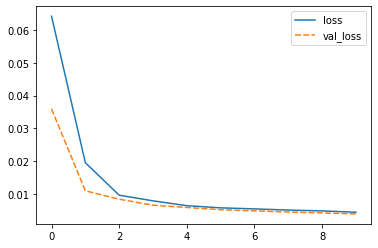

In [5]:
plot_training_curve(os.path.join(cnn_dest_path, 'training_metrics.csv'),
                    curve_names=['loss', 'val_loss'],
                    y_limit=False)

# Evaluate an ensemble of models

To run the ensembles for the unmixing problem, use the `evaluate_unmixing`
module and provide all necessary arguments.
It accepts following types of ensemble voting:
- mean, where the average of all models is computed
- booster, where an additional model is trained on the training set predictions

Each layer is modified separately. It is achieved by drawing a random number
for each of the parameters of the layer.
The number is drawn from the normal distribution with
provided mean and standard deviation calculated from the layer's parameters,
multiplied by `0.1`.

# Evaluate the mean ensemble:

In [6]:
from scripts.unmixing.evaluate_unmixing import evaluate

mean_dest_path = os.path.join(cnn_dest_path, 'noise-mean')
os.makedirs(mean_dest_path, exist_ok=True)
evaluate(data=data.copy(),
         model_path=os.path.join(cnn_dest_path, model_name),
         dest_path=mean_dest_path,
         neighborhood_size=neighborhood_size,
         batch_size=batch_size,
         endmembers_path=endmembers_path,
         use_ensemble=True,
         ensemble_copies=8,
         noise_params="{\"mean\": 0, \"std\": }",
         voting='mean')

c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])


# Evaluate the booster random forest regressor ensemble:

In [7]:
from scripts.unmixing.evaluate_unmixing import evaluate

booster_dest_path = os.path.join(cnn_dest_path, 'noise-booster')
os.makedirs(booster_dest_path, exist_ok=True)
evaluate(data=data.copy(),
         model_path=os.path.join(cnn_dest_path, model_name),
         dest_path=booster_dest_path,
         neighborhood_size=neighborhood_size,
         batch_size=batch_size,
         endmembers_path=endmembers_path,
         use_ensemble=True,
         ensemble_copies=8,
         noise_params="{\"mean\": 0, \"std\": }",
         voting='booster', # Booster type of voting
         voting_model='RFR', # Random Forest Regressor model
         voting_model_params="{}") # Default parameters

c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\tensorflow\python\framework\tensor_util.py:131: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.int_val.extend([np.asscalar(x) for x in proto_values])


# Original base model results:

In [8]:
show_statistics(os.path.join(cnn_dest_path, 'inference_metrics.csv'))

,aRMSE,aSAM,overallRMSE,rmsAAD,perClassSumRMSE,class0RMSE,class1RMSE,class2RMSE,class3RMSE,class4RMSE,class5RMSE,inference_time
0,0.05045,0.154137,0.066649,0.227918,0.39539,0.081193,0.068023,0.058313,0.053067,0.075524,0.059269,0.297013


# Mean results:

In [9]:
show_statistics(os.path.join(mean_dest_path,
                             'inference_metrics.csv'))

,aRMSE,aSAM,overallRMSE,rmsAAD,perClassSumRMSE,class0RMSE,class1RMSE,class2RMSE,class3RMSE,class4RMSE,class5RMSE,inference_time
0,0.062937,0.18116,0.078619,0.255331,0.464713,0.100972,0.079178,0.067611,0.056964,0.081861,0.078127,2.39901


# Booster results:

In [10]:
show_statistics(os.path.join(booster_dest_path,
                             'inference_metrics.csv'))

,aRMSE,aSAM,overallRMSE,rmsAAD,perClassSumRMSE,class0RMSE,class1RMSE,class2RMSE,class3RMSE,class4RMSE,class5RMSE,inference_time
0,0.022011,0.074186,0.038362,0.142907,0.22021,0.056896,0.030881,0.02539,0.025169,0.038791,0.043084,1.912657
